<img src="Olist_logo.png" width=100 height=100 align="left"/>

# Table of Contents

* [Data schema](#Data-schema)
* [Data understanding and transformation](#Data-understanding-and-transformation)
    * [Join order-centric dataframes (df_order, df_payment, df_review, df_customer, df_3_digit, df_geo_avg)](#Join-order-centric-dataframes-(df_order,-df_payment,-df_review,-df_customer,-df_3_digit,-df_geo_avg))
    * [Join item-centric dataframes (df_order_item, df_trans_product, df_seller, df_review, df-geo)](#Join-item-centric-dataframes-(df_order_item,-df_trans_product,-df_seller,-df_review,-df-geo))
    * [Create an item-user-review matrix for making recommendations](#Create-an-item-user-review-matrix-for-making-recommendations)
    * [Recommendation models with Surprise Package](#Recommendation-models-with-Surprise-Package)
* [Data exploration and visualization](#Data-exploration-and-visualization)
    * [Yearly trend of order number/overall payment value](#Yearly-trend-of-order-number/overall-payment-value)
    * [Order-centric variables](#Order-centric-variables)
        * [Distributions - payment type & payment value](#Distributions---payment-type-&-payment-value)
        * [Distributions - customer payment value](#Distributions---customer-payment-value)
        * [Distributions - customer wating time](#Distributions---customer-waiting-time)
        * [Distributions - customer purchase frequency (number of orders made by unique customer)](#Distributions---customer-purchase-frequency-(number-of-orders-made-by-unique-customer))
        * [Distributions - customer review score for the whole order](#Distributions---customer-review-score-for-the-whole-order)
        * [Geospatial order_density and payment_value distribution](#Geospatial-order_density-and-payment_value-distribution)
        * [Geospatial customer wating time distribution](#Geospatial-customer-wating-time-distribution)
    * [Item-centric variables](#Item-centric-variables)
        * [Distributions - product_category & price](#Distributions---product_category-&-price)
        * [Distributions - product_photos_qty](#Distributions---product_photos_qty)
        * [Distributions - seller_product_diversity](#Distributions---seller_product_diversity)
        * [Distributions - mean/overall selling price for each seller](#Distributions---mean/overall-selling-price-for-each-seller)
        * [Geospatial selling_price distribution](#Geospatial-selling_price-distribution)
    * [Seller_customer_distance distribution](#Seller_customer_distance-distribution)
    * [Correlation matrix](#Correlation-matrix)
        * [Order attributes](#Order-attributes)
        * [Item attributes](#Item-attributes)

## Data schema

<img src="Data_schema.png" width=900 height=400 align="left"/>

## Data understanding and transformation

In [9]:
# Import all required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns 
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
from functools import reduce

Brazil_map=mpimg.imread('/project/Brazil_map.png')

# Save image function
IMAGES_PATH = os.path.join('/project')
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
# Compute distance - vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


# Add percentage to plot function
def add_percentage_without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() /100
        y = p.get_y() + p.get_height() +100
        ax.annotate(percentage, (x, y), size = 10)
    plt.title('Credit card payment installment', fontsize=11)
    plt.show()
    

In [10]:
# Read in data files
df_customer = pd.read_csv("/project/olist_customers_dataset.csv")
df_geo = pd.read_csv("/project/olist_geolocation_dataset.csv")
df_order_item = pd.read_csv("/project/olist_order_items_dataset.csv")
df_payment = pd.read_csv("/project/olist_order_payments_dataset.csv")
df_review = pd.read_csv("/project/olist_order_reviews_dataset.csv")
df_order = pd.read_csv("/project/olist_orders_dataset.csv")
df_product = pd.read_csv("/project/olist_products_dataset.csv")
df_seller = pd.read_csv("/project/olist_sellers_dataset.csv")
df_trans = pd.read_csv("/project/product_category_name_translation.csv")

# Compute the size of each product by multiplying length, width and height
df_product['product_size'] = df_product['product_length_cm']*df_product['product_height_cm']*df_product['product_width_cm']
# Match product_category_name with translated English name
df_trans_product = pd.merge(df_product, df_trans, on='product_category_name')

# Rename 'zip_code_prefix' column in customer and seller dataframe for merging geo_info 
df_customer.rename(columns={'customer_zip_code_prefix': 'geolocation_zip_code_prefix'}, inplace=True)
df_seller.rename(columns={'seller_zip_code_prefix': 'geolocation_zip_code_prefix'}, inplace=True)

# Create 3_digit_zip_code variable for zip_code_prefix location
df_geo_str = df_geo.astype({"geolocation_zip_code_prefix":str})
df_geo_str['geolocation_zip_code_prefix_3_digits'] = df_geo_str['geolocation_zip_code_prefix'].str[0:3].astype(int)
df_3_digit = df_geo_str[['geolocation_zip_code_prefix', 'geolocation_zip_code_prefix_3_digits']]
df_3_digit = df_3_digit.astype({"geolocation_zip_code_prefix":int})
df_3_digit = df_3_digit.drop_duplicates()

# Compute average latitude and longitude for each geolocation_zip_code_prefix
df_geo_avg = df_geo.groupby('geolocation_zip_code_prefix').mean().reset_index()

# Compute the average review_score for each order
df_review_avg = df_review.groupby(['order_id']).mean()


# The reason why there're more records for df_payment is that customers may use different payment methods for certain order
# Adding up the payment_value per order and create a new dataframe
df_payment_value = df_payment.groupby('order_id')['payment_value'].sum().to_frame()

# Convert df_order timestamp to datetime type
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])
df_order['order_approved_at'] = pd.to_datetime(df_order['order_approved_at'])
df_order['order_delivered_carrier_date'] = pd.to_datetime(df_order['order_delivered_carrier_date'])
df_order['order_delivered_customer_date'] = pd.to_datetime(df_order['order_delivered_customer_date'])
df_order['order_estimated_delivery_date'] = pd.to_datetime(df_order['order_estimated_delivery_date'])

# Compute system/seller processing time (to Days) = 'order_delivered_carrier_date' - 'order_purchase_timestamp'
df_order['processing_time'] =(df_order['order_delivered_carrier_date'] - df_order['order_purchase_timestamp'])/np.timedelta64(1,'D')
# Compute delivery time = 'order_delivered_customer_date' - 'order_delivered_carrier_date'
df_order['delivery_time'] =(df_order['order_delivered_customer_date'] - df_order['order_delivered_carrier_date'])/np.timedelta64(1,'D')
# Compute customer waiting time (to Days) = 'order_delivered_customer_date' - 'order_purchase_timestamp'
df_order['customer_waiting'] =(df_order['order_delivered_customer_date'] - df_order['order_purchase_timestamp'])/np.timedelta64(1,'D')
# Compute estimated and actual delivery time gap ='order_estimated_delivery_date' - 'order_delivered_customer_date'
df_order['estimated_actual_time_gap'] =(df_order['order_estimated_delivery_date'] - df_order['order_delivered_customer_date'])/np.timedelta64(1,'D')

Why do we choose 3_digit_zip_code areas instead of 4_digit and 2_digit?

Zip codes with 1 digit include areas in one or two states. Zip codes with 2 digits are multiple neighbourhoods in the same city. Zip codes with 3 digits represent one single neighbourhood, which has the suitable size for plotting on maps.

#### Join order-centric dataframes (df_order, df_payment, df_review, df_customer, df_3_digit, df_geo_avg)

In [11]:
# Join order, payment_value and review dataframe by order_id
df_order_payment_value_review = reduce(lambda left,right: pd.merge(left,right,on='order_id'), [df_order, df_payment_value, df_review_avg])
# Join customer dataframe by customer_id and geolocation dataframes by geolocation_zip_code_prefix
df_order_payment_review_customer_3_digit_geo = df_order_payment_value_review.merge(df_customer, on='customer_id', how='left').merge(df_3_digit,on='geolocation_zip_code_prefix', how='left').merge(df_geo_avg, on='geolocation_zip_code_prefix', how='left')
# Rename columns containing geo_info to avoid confusion with seller geo_info
df_order_payment_review_customer_3_digit_geo.rename(columns={'geolocation_zip_code_prefix':'customer_zip_code','geolocation_zip_code_prefix_3_digits':'customer_3_digit_zip_code',
                                                            'geolocation_lat':'customer_lat', 'geolocation_lng':'customer_lng'}, inplace=True)

## Create new features

# Count the number of orders made by unique customers
df_order_number = df_order_payment_review_customer_3_digit_geo.groupby('customer_unique_id')['order_id'].count().to_frame()
df_order_number.reset_index(inplace=True)
df_order_number.rename(columns={'order_id':'no_of_orders_per_cus'}, inplace=True)

# Merge into order_centric dataframe
df_order_c = df_order_payment_review_customer_3_digit_geo.merge(df_order_number, on='customer_unique_id', how ='left')

# See basic info
df_order_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99440 entries, 0 to 99439
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99440 non-null  object        
 1   customer_id                    99440 non-null  object        
 2   order_status                   99440 non-null  object        
 3   order_purchase_timestamp       99440 non-null  datetime64[ns]
 4   order_approved_at              99280 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97657 non-null  datetime64[ns]
 6   order_delivered_customer_date  96475 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99440 non-null  datetime64[ns]
 8   processing_time                97657 non-null  float64       
 9   delivery_time                  96474 non-null  float64       
 10  customer_waiting               96475 non-null  float64       
 11  estimated_actua

#### Join item-centric dataframes (df_order_item, df_trans_product, df_seller, df_review, df-geo)

In [12]:
# Join order_item and trans_product dataframe by product_id, seller dataframe by seller_id, geolocation dataframe by geolocation_zip_code_prefix
df_order_item_product_seller_3_digit_review= df_order_item.merge(df_trans_product,on='product_id', how='left').merge(
    df_seller,on='seller_id', how='left').merge(df_3_digit,on='geolocation_zip_code_prefix', how='left').merge(
    df_geo_avg,on='geolocation_zip_code_prefix', how='left').merge(
    df_review_avg,on='order_id', how='left')
# Rename columns containing geo_info to avoid confusion with customer geo_info and correct some typos
df_order_item_product_seller_3_digit_review.rename(columns={'geolocation_zip_code_prefix':'seller_zip_code', 
                                                            'geolocation_zip_code_prefix_3_digits':'seller_3_digit_zip_code', 
                                                            'geolocation_lat':'seller_lat', 'geolocation_lng':'seller_lng', 
                                                            'product_name_lenght':'product_name_length', 
                                                            'product_description_lenght':'product_description_length'}, inplace=True)

## Create new features
# Compute average review_score for each product to represent product quality 
df_product_review= df_order_item_product_seller_3_digit_review.groupby('product_id')['review_score'].mean().reset_index()
## Rename column to avoid confusion with review score of the whole order
df_product_review.rename(columns={'review_score':'product_avg_review_score'}, inplace=True)


# seller_sum_price is the overall selling price of each seller
df_sel_sum_price = df_order_item_product_seller_3_digit_review.groupby('seller_id')['price'].sum().to_frame()
df_sel_sum_price.reset_index(inplace=True)
df_sel_sum_price.rename(columns={'price':'seller_sum_price'}, inplace=True)
# seller_avg_price is the mean selling price across all the orders of each seller 
df_sel_avg_price = df_order_item_product_seller_3_digit_review.groupby('seller_id')['price'].mean().to_frame()
df_sel_avg_price.reset_index(inplace=True)
df_sel_avg_price.rename(columns={'price':'seller_avg_price'}, inplace=True)
# seller_product_diversity
df_seller_category = df_order_item_product_seller_3_digit_review.groupby('seller_id')['product_category_name_english'].nunique().to_frame()
df_seller_category.reset_index(inplace=True)
df_seller_category.rename(columns={'product_category_name_english':'seller_product_diversity'}, inplace=True)

# Merge into item_centric dataframe
df_item_c = df_order_item_product_seller_3_digit_review.merge(df_product_review, on='product_id', how='left').merge(
                     df_sel_sum_price, on='seller_id', how='left').merge(df_sel_avg_price, on='seller_id', how='left').merge(                 
                        df_seller_category, on='seller_id', how='left')
df_item_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   product_category_name          111023 non-null  object 
 8   product_name_length            111023 non-null  float64
 9   product_description_length     111023 non-null  float64
 10  product_photos_qty             111023 non-null  float64
 11  product_weight_g               111022 non-null  float64
 12  product_length_cm             

#### Create an item-user-review matrix for making recommendations

In [13]:
# Create an inclusive dataframe by joining order_centric and item_centric dataframes
df_all = df_item_c.merge(df_order_c, on='order_id', how='left')
# Remove review_score_y column as it's the same as review_score_x
df_all.drop('review_score_y', axis=1, inplace=True)
# Create sel_cus_distance feature
df_all['sel_cus_distance'] = haversine(df_all['seller_lat'], df_all['seller_lng'], df_all['customer_lat'], df_all['customer_lng'])


# Select related columns
df_matrix = df_all[['product_id','review_score_x','customer_id','order_purchase_timestamp']].copy()

# Some order consists of different products yet others same
# Remove all duplicated rows and null values
df_matrix.drop_duplicates(inplace=True)
df_matrix.dropna(inplace=True)
df_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102424 entries, 0 to 112649
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   product_id                102424 non-null  object        
 1   review_score_x            102424 non-null  float64       
 2   customer_id               102424 non-null  object        
 3   order_purchase_timestamp  102424 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.9+ MB


In [14]:
# For running models, we need to create product_float_id correspondent with product_id
df_product_id = df_all[['product_id']].drop_duplicates()
df_product_id['product_float_id'] = np.arange(1,32952)

df_customer_id = df_all[['customer_id']].drop_duplicates()
df_customer_id['customer_float_id'] = np.arange(1,98667)

# Merge new id into df_rec
df_rec = df_matrix.merge(df_product_id, on='product_id', how='left').merge(df_customer_id, on='customer_id', how='left')
df_r = df_rec.drop(['product_id', 'customer_id'], axis = 1)

# Re-order Columns
df_r = df_r[['customer_float_id','product_float_id','review_score_x','order_purchase_timestamp']]
df_r.rename(columns={'customer_float_id':'userID','product_float_id':'itemID','review_score_x':'rating'}, inplace=True)
df_r.tail(2)
#df_r.info()
n_users=int(df_r.userID.nunique())
n_items=int(df_r.itemID.nunique())
print("n_users = ",n_users, "||", "n_items = ", n_items )

,userID,itemID,rating,order_purchase_timestamp
102422,98665,10335,5.0,2017-08-14 23:02:59
102423,98666,32951,5.0,2018-06-09 17:00:18


n_users =  98665 || n_items =  32951


#### Recommendation models with Surprise Package

In [15]:
! pip install surprise
from surprise import dataset
from surprise import Reader
#from surprise import evaluate, print_perf
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

In [16]:
# Create a dummy reader
reader = Reader(line_format='user item rating', rating_scale=(1, 5))

# Create a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userID'], df['itemID'], df['rating'])]
        self.reader=reader

data = MyDataset(df_r, reader)

trainset, testset = train_test_split(data, test_size=.2, random_state=123)

In [17]:
from surprise import SVD
algo_svd = SVD(random_state=42)
# Train the algorithm on the trainset, and predict ratings for the testset
algo_svd.fit(trainset)

predictions_svd = algo_svd.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_svd)

RMSE: 1.3294


1.3294169243954967

In [18]:
from surprise import NMF
algo_nmf = NMF(random_state=42)
algo_nmf.fit(trainset)

predictions_nmf = algo_nmf.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_nmf)

RMSE: 1.3172


1.3172357271005737

## Data exploration and visualization

### Yearly trend of order number/overall payment value

In [19]:
df_order_c['purchase_month_year'] = df_order_c['order_purchase_timestamp'].dt.strftime('%Y-%m')

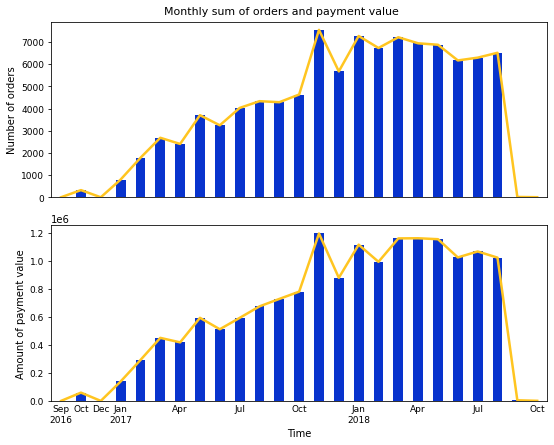

In [20]:
fig, ax =plt.subplots(2,1,figsize=(8,6))
ax1 = df_order_c.groupby("purchase_month_year")['order_id'].nunique().plot(kind = "bar", color = '#0833CD', ax=ax[0])
df_order_c.groupby("purchase_month_year")['order_id'].nunique().plot(kind = "line", color = '#FFC520', linewidth=2.5, ax=ax[0])
ax2 = df_order_c.groupby("purchase_month_year")['payment_value'].sum().plot(kind = "bar", color = '#0833CD', ax=ax[1])
df_order_c.groupby("purchase_month_year")['payment_value'].sum().plot(kind = "line", color = '#FFC520', linewidth=2.5, ax=ax[1])
ax1.axes.xaxis.set_visible(False)
ax1.set_ylabel('Number of orders')
ax2.set_ylabel('Amount of payment value')
plt.xlabel("Time", fontsize=10)
plt.tight_layout()
#plt.xticks(rotation=65)
# hide tick lines for x axis
ax2.tick_params(axis='x', which='both',length=0)
tick_labels=['Sep','\n2016','Oct','','Dec','','Jan','\n2017',' ','',' ','','Apr','',' ','',
             ' ','','Jul','',' ','',' ','','Oct','',' ','',' ','','Jan','\n2018',' ','',' ','','Apr','',' ','',
             ' ','','Jul','',' ','',' ','','Oct','']
tick_locations = np.arange(25)
new_labels = [ ''.join(x) for x in zip(tick_labels[0::2], tick_labels[1::2]) ]
plt.xticks(tick_locations, new_labels,  fontsize=9)
ax2.tick_params(axis='both', which='major', labelsize=9)
ax1.tick_params(axis='y', which='major', labelsize=9)
plt.suptitle('Monthly sum of orders and payment value', y=1.01, horizontalalignment='center', 
             verticalalignment='top', fontsize = 11)
plt.savefig('time series.png', dpi=300, bbox_inches='tight');

### Order-centric variables

#### Distributions - payment type & payment value

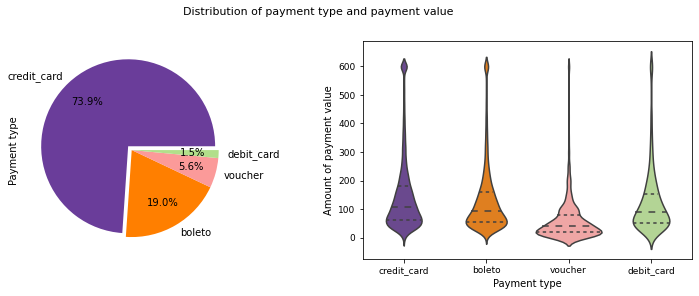

In [21]:
# Remove 3 rows where payment_type is not defined
df_payment.drop(df_payment.loc[df_payment['payment_type']=='not_defined'].index, inplace=True)
df_payment['payment_value'].values[df_payment['payment_value']  > 600] = 600

fig, ax =plt.subplots(1,2,figsize=(13,4))
cmap = plt.get_cmap("Paired")
explode = (0.06, 0, 0, 0)
df_payment['payment_type'].value_counts().plot.pie(colors=cmap(np.array([9,7,4,2])), 
                                    explode=explode, autopct='%1.1f%%', pctdistance=0.7, ax=ax[0])
sns.violinplot(x=df_payment.payment_type, y=df_payment.payment_value, palette='Paired_r', inner='quartile', ax=ax[1])

ax[0].tick_params(axis='y', which='major', labelsize=9)
ax[1].tick_params(axis='both', which='major', labelsize=9)
plt.suptitle('Distribution of payment type and payment value', y=1.0, horizontalalignment='center', 
             verticalalignment='top', fontsize =11)
ax[0].set_ylabel('Payment type',fontsize=10)
ax[1].set_ylabel('Amount of payment value', fontsize=10)
ax[1].set_xlabel('Payment type', fontsize=10)
plt.savefig('payment methods.png', dpi=300, bbox_inches='tight');
#plt.show();

In [22]:
# Add percentage to plot function
def add_percentage_without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() /100
        y = p.get_y() + p.get_height() +100
        ax.annotate(percentage, (x, y), size = 10)
    ax.set_xlabel('Payment installment', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)
    plt.title('Distribution of credit card payment installment', fontsize=11)
    plt.savefig('payment installment.png', dpi=300, bbox_inches='tight');
    plt.show();

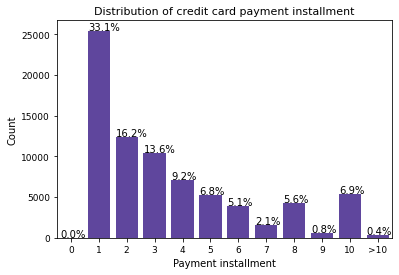

In [23]:
df_credit = df_payment[df_payment['payment_type']=='credit_card']
df_credit['payment_installments'].values[df_credit['payment_installments']  > 10] = 11
ax = sns.countplot(df_credit['payment_installments'], palette=['#5938AB'])
ax.set_xticklabels(['0','1','2','3','4','5','6','7','8','9','10','>10'])

add_percentage_without_hue(ax, df_credit['payment_installments']);


<br>
<div class="alert alert-info">
    <b>Note:</b> 
Boleto is a payment method in Brazil regulated by Brazilian Federation of Banks. A boleto can be paid at ATMs, branch facilities and internet banking of any Bank, Post Office, Lottery Agent and some supermarkets until its due date. After the due date it can only be paid at the issuer bank facilities. Boleto can only be collected by an authorized Collector Agent in the Brazilian territory. All Brazilian banks, Post Offices (Correios) and Lottery Agencies plus some companies from the private sector have joined the system.
</div>

#### Distributions - customer payment value

In [24]:
# Replace outliers for better visualization
# Exclude outliers where customers' geolocation is outside Brazil 
df_1 = df_order_c.query("customer_lat <= 5.27438888 & customer_lat >= -33.75116944 & customer_lng <= -34.79314722 & customer_lng >= -73.98283055")

''

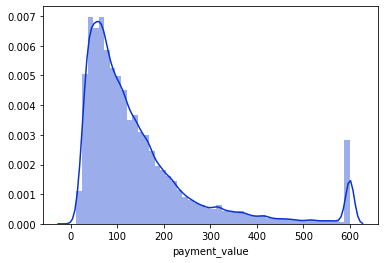

In [25]:
# The distribution of payment value has a really long tail, so the threshold of payment_value is set to 600
df_1['payment_value'].values[df_1['payment_value']  > 600] = 600
#sns.set_palette('dark')
sns.set_palette(sns.color_palette(['#0833CD']))
sns.distplot(df_1['payment_value'])
;

#### Distributions - customer wating time

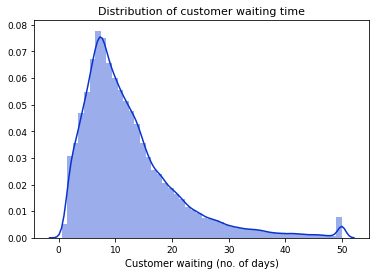

In [26]:
# Customer_waiting measures the time gap between customer making the purchase and receiving the packages
# Threshold was set to 50 based on the observations of the original distribution
df_1['customer_waiting'].values[df_1['customer_waiting']  > 50] = 50
sns.set_palette(sns.color_palette(['#0833CD']))
ax = sns.distplot(df_1['customer_waiting'])
ax.set_xlabel('Customer waiting (no. of days)', fontsize=10)
#ax.set_ylabel('Count', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of customer waiting time', fontsize=11)
plt.savefig('customer_waiting.png', dpi=300, bbox_inches='tight');

#### Distributions - customer purchase frequency (number of orders made by unique customer)

In [27]:
# Add percentage to plot function
def add_percentage_without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() /100
        y = p.get_y() + p.get_height() +100
        ax.annotate(percentage, (x, y), size = 10)
    ax.set_xlabel('No. of orders made by unique customer', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)
    plt.title('Distribution of customer purchase frequency', fontsize=11)
    plt.savefig('purchase frequency.png', dpi=300, bbox_inches='tight');
    plt.show();

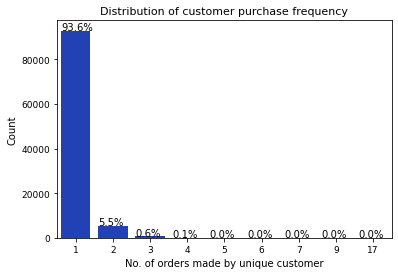

In [28]:
ax = sns.countplot(df_1['no_of_orders_per_cus'], palette=['#0833CD'])
add_percentage_without_hue(ax, df_1['no_of_orders_per_cus']);

#### Distributions - customer review score for the whole order

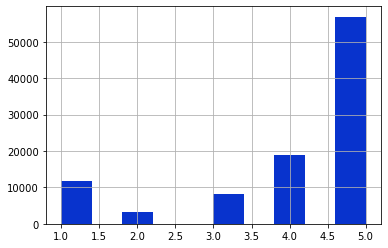

In [29]:
df_1['review_score'].hist(figsize=(6,4), color='#0833CD');

#### Geospatial order_density and payment_value distribution

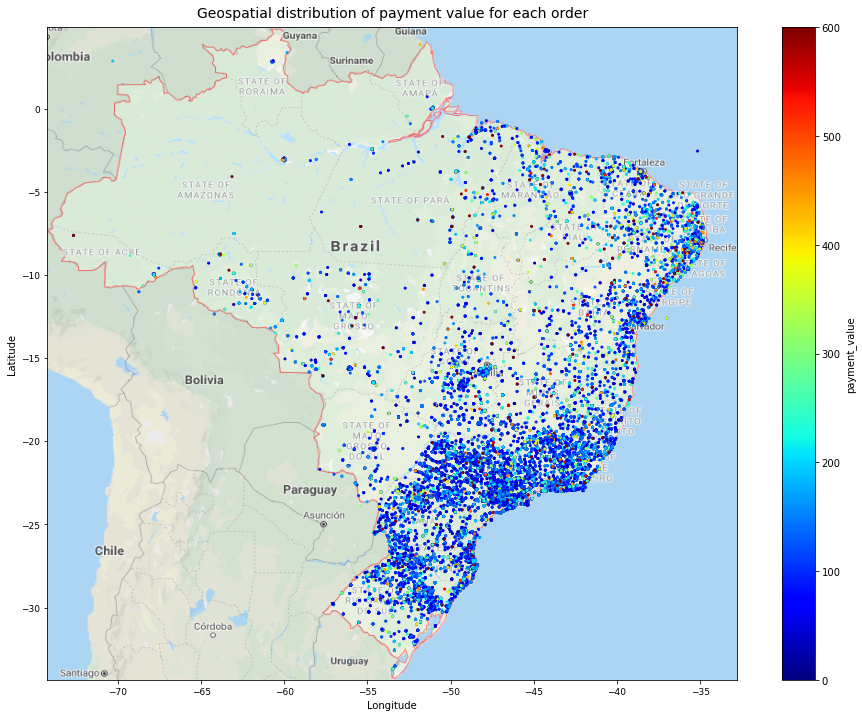

In [30]:
df_1.plot(kind="scatter", x="customer_lng", y="customer_lat", alpha=1.0, figsize=(16,12), s=4, 
          c="payment_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
#plt.imshow(Brazil_map, extent=[-73.98283055, -32.934892, -33.75116944, 5.27438888])
plt.imshow(Brazil_map, extent=[-74.25, -32.76, -34.34, 4.87], alpha=0.8)
plt.ylabel("Latitude", fontsize=10)
plt.xlabel("Longitude", fontsize=10)
plt.title("Geospatial distribution of payment value for each order", fontsize=14, pad=10)
# Increase dpi of imshow figure
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('payment_value_geo.png', dpi=300, bbox_inches='tight');
## plt.rcParams['figure.dpi'] = 800
plt.show();

<br>
<div class="alert alert-info">
    <b>Note:</b> 
 As the coordinates are computed by the average of each zip_code_prefix, which captures the center of the area. So there's error between geospatial plot and the actual geolocation. 
</div>

Plotting payment value per order didn't show explicit geospatial patterns. By summing the payment_value by the first three digits of each zip_code_prefix, we get the graph below:

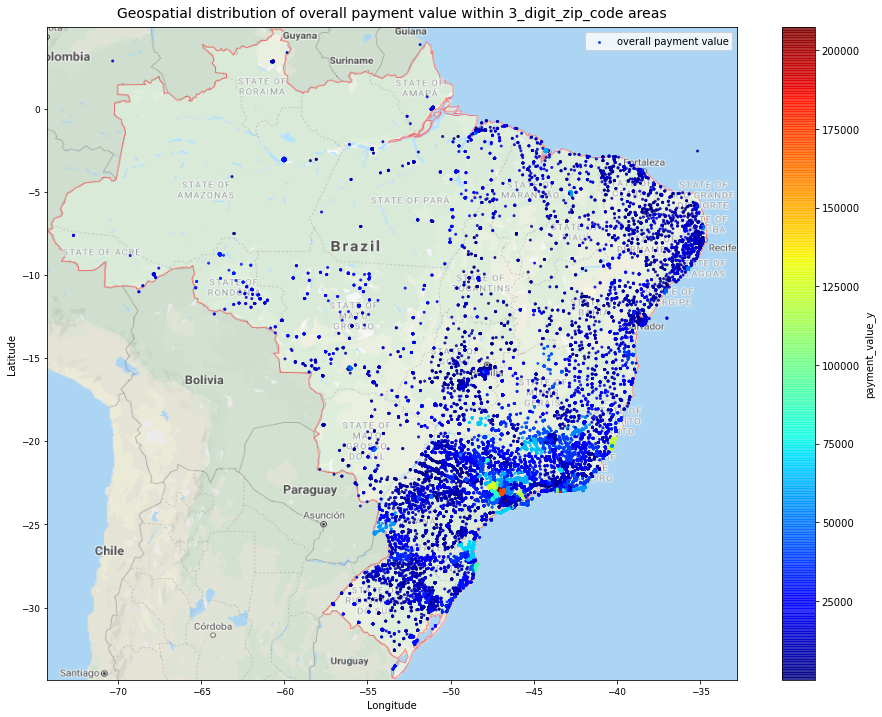

In [31]:
df_2 = df_1.groupby('customer_3_digit_zip_code')['payment_value'].sum().to_frame()
df_3 = df_1.merge(df_2, on='customer_3_digit_zip_code', how ='left')
df_3.plot(kind="scatter", x="customer_lng", y="customer_lat", alpha=0.8, figsize=(16,12), s=4, 
          c="payment_value_y", label='overall payment value',cmap=plt.get_cmap("jet"), colorbar=True,  sharex=False)
#plt.imshow(Brazil_map, extent=[-73.98283055, -32.934892, -33.75116944, 5.27438888])
plt.imshow(Brazil_map, extent=[-74.25, -32.76, -34.34, 4.87], alpha=0.8)
plt.ylabel("Latitude", fontsize=10)
plt.xlabel("Longitude", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.title("Geospatial distribution of overall payment value within 3_digit_zip_code areas", fontsize=14, pad=10)
plt.savefig('payment_value_geo_b.png', dpi=300, bbox_inches='tight');
plt.show();

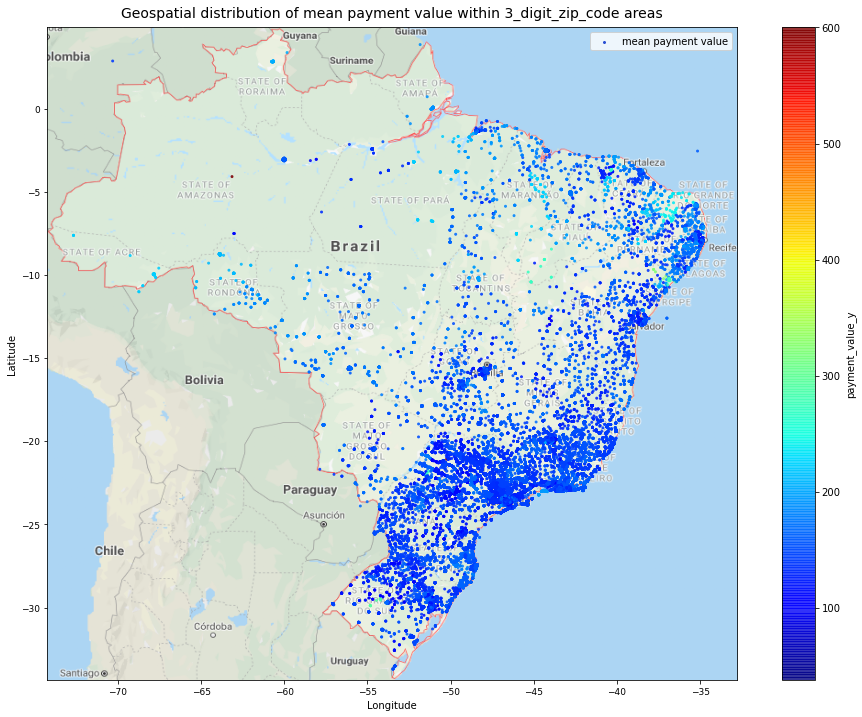

In [32]:
df_4 = df_1.groupby('customer_3_digit_zip_code')['payment_value'].mean().to_frame()
df_5 = df_1.merge(df_4, on='customer_3_digit_zip_code', how ='left')
df_5.plot(kind="scatter", x="customer_lng", y="customer_lat", alpha=0.8, figsize=(16,12), s=4, 
          c="payment_value_y", label='mean payment value', cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.imshow(Brazil_map, extent=[-74.25, -32.76, -34.34, 4.87], alpha=0.8)
plt.ylabel("Latitude", fontsize=10)
plt.xlabel("Longitude", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.title("Geospatial distribution of mean payment value within 3_digit_zip_code areas", fontsize=14, pad=10)
plt.savefig('payment_value_geo_b.png', dpi=300, bbox_inches='tight');
plt.show();

<div class="alert alert-success">
<b> Different ways for geospatial exploration </b> 

<p>The graphs above show different ways to plotting payment_value. The first one plotted each order individually, however, caused confusion by overlapping points and showed no obvious patterns. The second one summed the overall payment_value within zip_code_3_digits areas and showed higher values around big cities. The third one caculated the mean payment_value within zip_code_3_digits areas and showed higher values in the northeast and west of Brazil. In conclusion, the overall payment_value around big cities southeast of Brazil is higher because order density is higher in that area (probabbly due to larger population), rather than  higher mean value of each order. </p> 

</div>

#### Geospatial customer wating time distribution

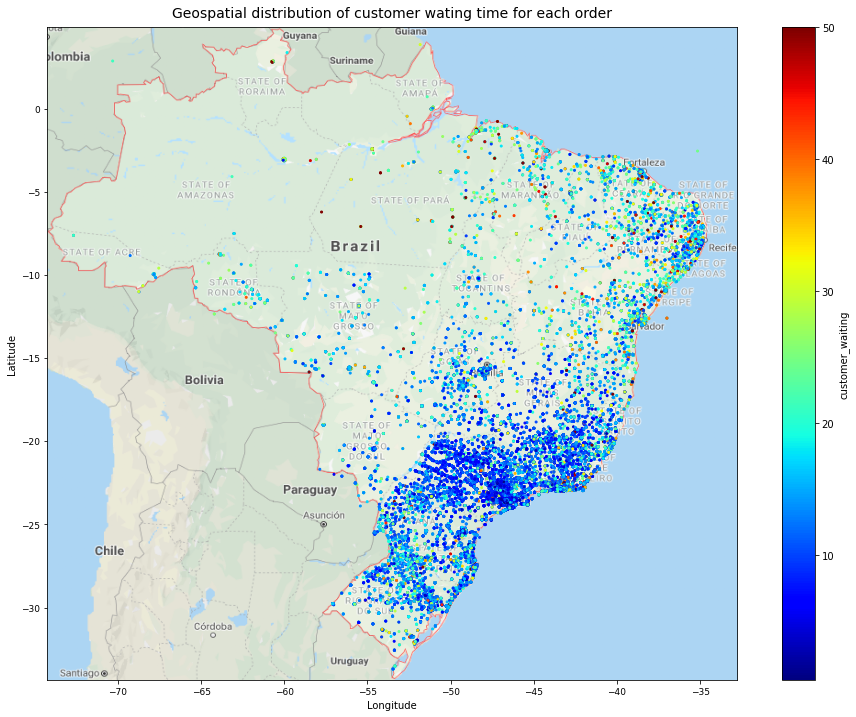

In [33]:
df_1.plot(kind="scatter", x="customer_lng", y="customer_lat", alpha=1.0, figsize=(16,12), s=4, 
        c="customer_waiting", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.imshow(Brazil_map, extent=[-74.25, -32.76, -34.34, 4.87], alpha=0.8)
plt.ylabel("Latitude", fontsize=10)
plt.xlabel("Longitude", fontsize=10)
plt.title("Geospatial distribution of customer wating time for each order", fontsize=14, pad=10)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('payment_value_geo_b.png', dpi=300, bbox_inches='tight');
plt.show();

<div class="alert alert-success">

<p> It's easy to see that customer waiting time is shorter around big cities in the southeast than that in the northeast and west. </p> 

</div>

### Item-centric variables

In [34]:
# Exclude outliers where sellers' geolocation is outside Brazil 
df_a = df_item_c.query("seller_lat <= 5.27438888 & seller_lat >= -33.75116944 & seller_lng <= -34.79314722 & seller_lng >= -73.98283055")

# Create unique_seller dataframe
df_unique_seller = df_a.drop_duplicates(subset='seller_id')

#### Distributions - product_category & price

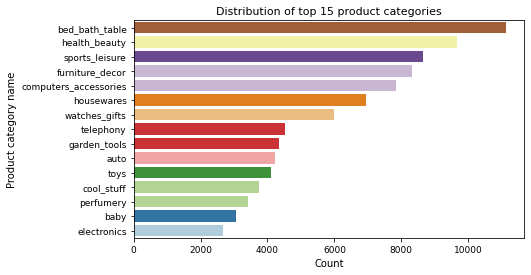

In [35]:
# Visualize distributions of categorical variables - product_category
plt.figure(figsize=(7,4))
ax = sns.countplot(y='product_category_name_english', data=df_a,  palette='Paired_r',
                   order=df_a.product_category_name_english.value_counts().iloc[:15].index)
ax.set_xlabel('Count', fontsize=10)
ax.set_ylabel('Product category name', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of top 15 product categories', fontsize=11)
plt.savefig('product categories.png', dpi=300, bbox_inches='tight');
plt.show();

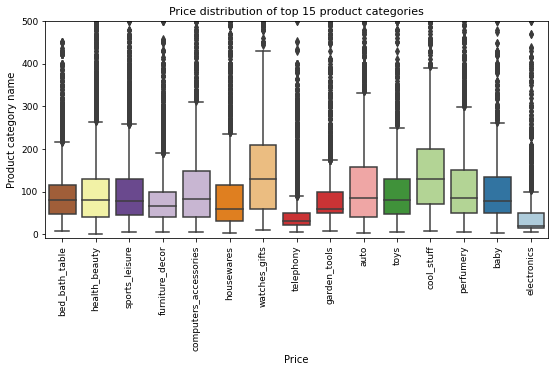

In [36]:
plt.figure(figsize=(9,4))
ax=sns.boxplot(x=df_a.product_category_name_english, y=df_a.price, 
                  order=df_a.product_category_name_english.value_counts().iloc[:15].index, palette='Paired_r')
ax.set(ylim=(-10,500))
plt.xticks(rotation=90)
ax.set_xlabel('Price', fontsize=10)
ax.set_ylabel('Product category name', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Price distribution of top 15 product categories', fontsize=11)
plt.savefig('product price.png', dpi=300, bbox_inches='tight');
plt.show();

#### Distributions - product_photos_qty

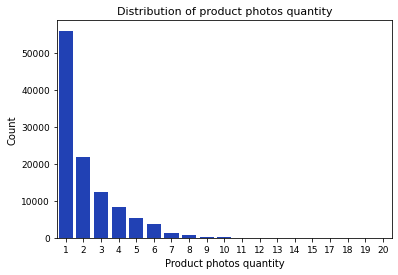

In [46]:
plt.figure(figsize=(6,4))
ax = sns.countplot(df_a['product_photos_qty'], palette=['#0833CD'])
ax.set_xticklabels(['{:.0f}'.format(float(t.get_text())) for t in ax.get_xticklabels()]);

ax.set_xlabel('Product photos quantity', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of product photos quantity', fontsize=11)
plt.savefig('product photo.png', dpi=300, bbox_inches='tight');

In [48]:
len(df_a)

112397

#### Distributions - seller_product_diversity

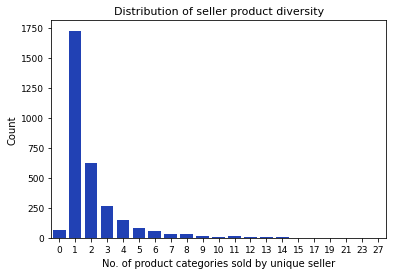

In [47]:
plt.figure(figsize=(6,4))
ax=sns.countplot(df_unique_seller['seller_product_diversity'], palette=['#0833CD']);


ax.set_xlabel('No. of product categories sold by unique seller', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of seller product diversity', fontsize=11)
plt.savefig('product photo.png', dpi=300, bbox_inches='tight');

#### Distributions - mean/overall selling price for each seller

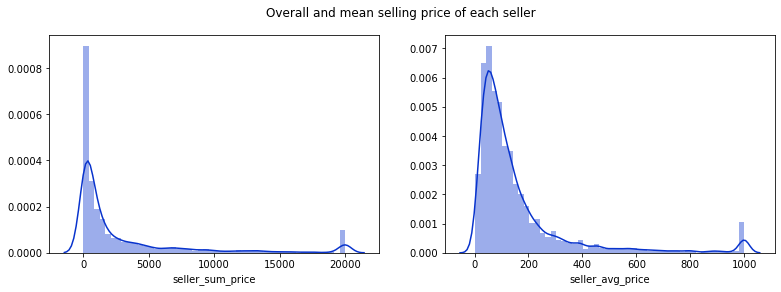

In [39]:
# Set threshold 
df_unique_seller['seller_sum_price'].values[df_unique_seller['seller_sum_price']  > 20000] = 20000
df_unique_seller['seller_avg_price'].values[df_unique_seller['seller_avg_price']  > 1000] = 1000

fig, ax =plt.subplots(1,2,figsize=(13, 4))
plt.suptitle("Overall and mean selling price of each seller", fontsize=12)
sns.set_palette(sns.color_palette(['#0833CD']))
sns.distplot(df_unique_seller['seller_sum_price'], ax=ax[0])
sns.distplot(df_unique_seller['seller_avg_price'], ax=ax[1])
fig.show();

#### Geospatial selling_price distribution

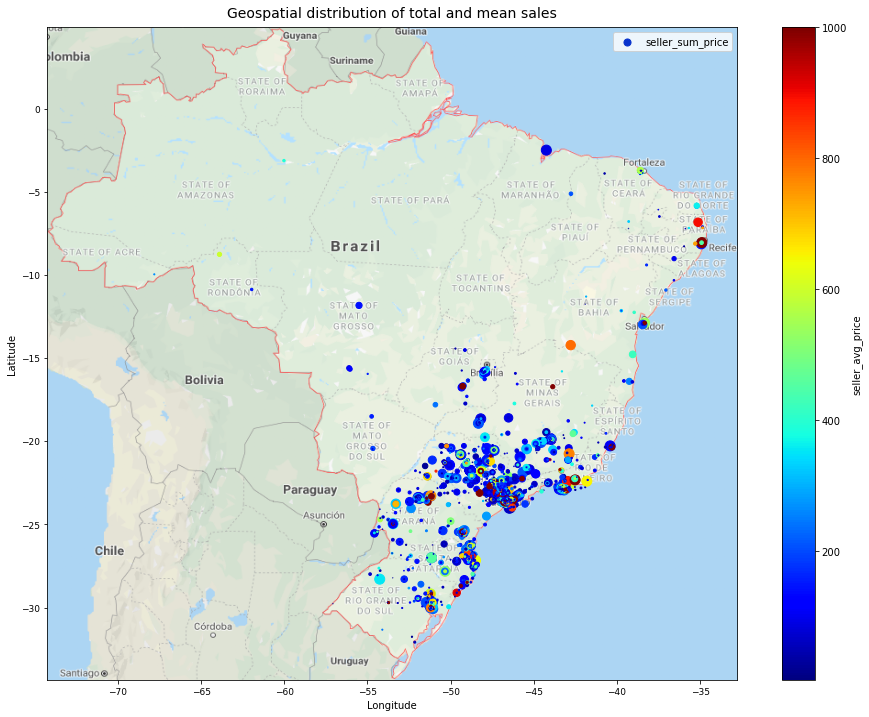

In [40]:
# Each point plotted each seller, size of the points measures the overall selling price, the color shows the mean selling price
df_unique_seller.plot(kind="scatter", x="seller_lng", y="seller_lat", alpha=1.0, figsize=(16,12), 
           s=df_unique_seller['seller_sum_price']/200, label="seller_sum_price",
        c="seller_avg_price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.imshow(Brazil_map, extent=[-74.25, -32.76, -34.34, 4.87], alpha=0.8)
plt.ylabel("Latitude", fontsize=10)
plt.xlabel("Longitude", fontsize=10)
plt.title("Geospatial distribution of total and mean sales", fontsize=14, pad=10)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('seller_dis.png', dpi=300, bbox_inches='tight');
plt.show();

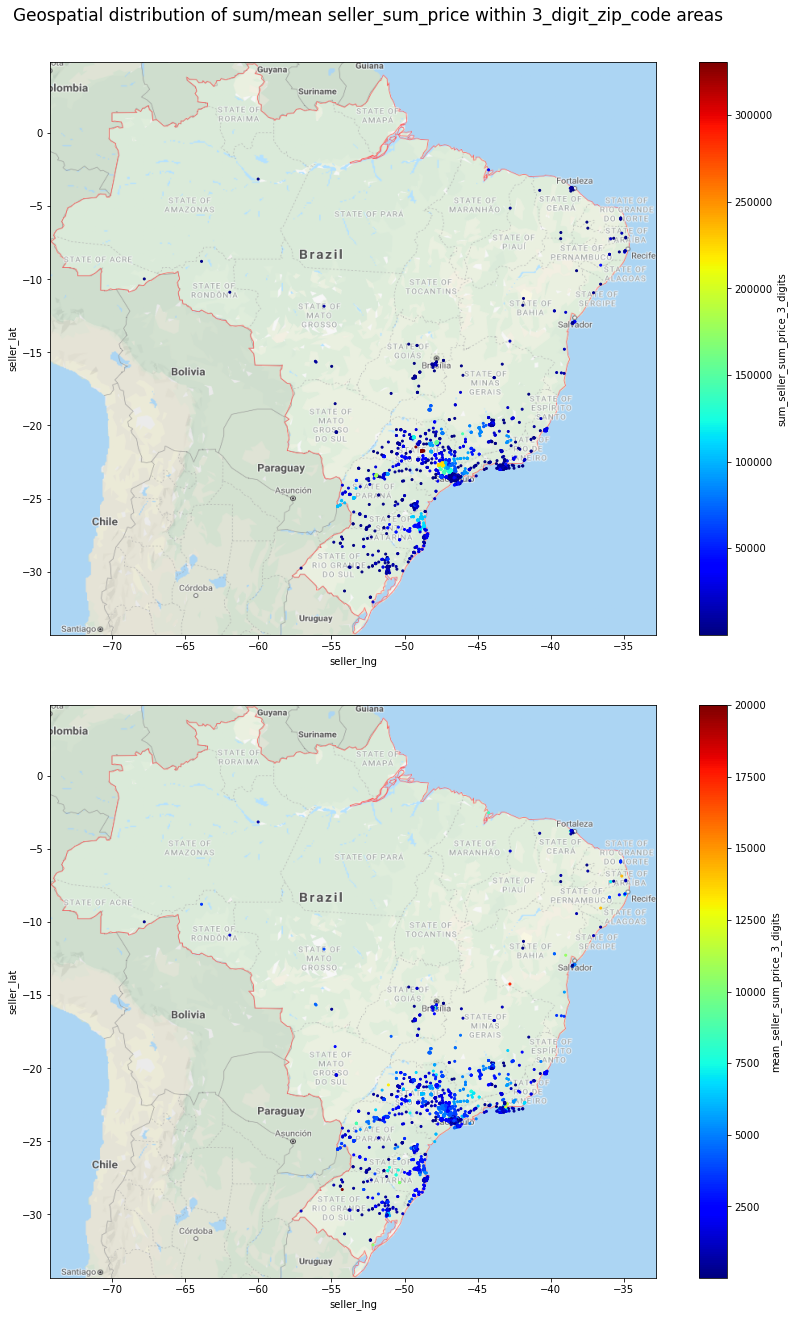

In [41]:
df_b_1 = df_unique_seller.groupby('seller_3_digit_zip_code')['seller_sum_price'].sum().to_frame()
df_b_2 = df_unique_seller.groupby('seller_3_digit_zip_code')['seller_sum_price'].mean().to_frame()

df_b_1.rename(columns={'seller_sum_price':'sum_seller_sum_price_3_digits'}, inplace=True)
df_b_2.rename(columns={'seller_sum_price':'mean_seller_sum_price_3_digits'}, inplace=True)

df_c = df_unique_seller.merge(df_b_1, on='seller_3_digit_zip_code', how ='left').merge(df_b_2, on='seller_3_digit_zip_code', how ='left')

fig, ax =plt.subplots(2,1)

df_c.plot(kind="scatter", x="seller_lng", y="seller_lat", alpha=1.0, figsize=(16,12), s=4,
         c="sum_seller_sum_price_3_digits", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False,  ax=ax[0])
ax[0].imshow(Brazil_map, extent=[-74.25, -32.76, -34.34, 4.87], alpha=0.8)

df_c.plot(kind="scatter", x="seller_lng", y="seller_lat", alpha=1.0, figsize=(16,12), s=4,
         c="mean_seller_sum_price_3_digits", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False,  ax=ax[1])
ax[1].imshow(Brazil_map, extent=[-74.25, -32.76, -34.34, 4.87], alpha=0.8)

plt.tight_layout()
plt.suptitle('Geospatial distribution of sum/mean seller_sum_price within 3_digit_zip_code areas',
             x=0.05, y=1.03, horizontalalignment='left', verticalalignment='top', fontsize = 17)
fig.set_size_inches(12,18)
plt.show();

<div class="alert alert-success">
<b> Different ways for geospatial exploration </b> 

<p> By plotting the sum and mean value of each seller's overall selling price, still we can conclude the overall seller_sum_price within 3_digit_zip_code areas is higher around Sao Paulo because of higher seller density instead of higher mean seller_sum_price achieved individually.  </p> 

</div>

### Seller_customer_distance distribution

In [42]:
# df_all['sel_cus_distance'].values[df_all['sel_cus_distance'] > 3000] = 3000
# sns.set_palette(sns.color_palette(['#0833CD']))
# sns.distplot(df_all['sel_cus_distance']);

### Correlation matrix

#### Order attributes

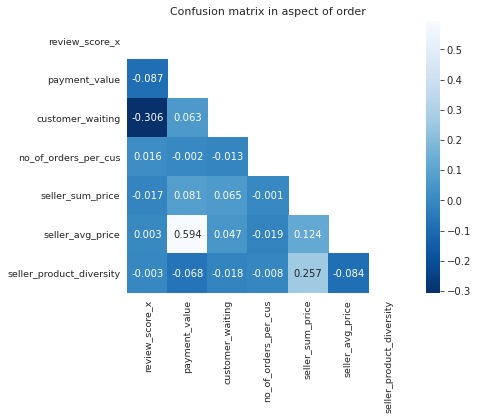

In [43]:
df_corr_order=pd.DataFrame(df_all, columns=['review_score_x', 'payment_value','customer_waiting','no_of_orders_per_cus','seller_sum_price',
                                       'seller_avg_price', 'seller_product_diversity'])

corr1= df_corr_order.corr()
mask = np.zeros_like(corr1)
mask[np.triu_indices_from(corr1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(6.3,5))
    ax = sns.heatmap(corr1, mask=mask, annot=True, fmt=".3f", cmap= 'Blues_r')
plt.xticks(rotation=90);
plt.title("Confusion matrix in aspect of order", fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=9.5)
plt.savefig('seller_dis.png', dpi=300, bbox_inches='tight');
plt.show();

#### Item attributes

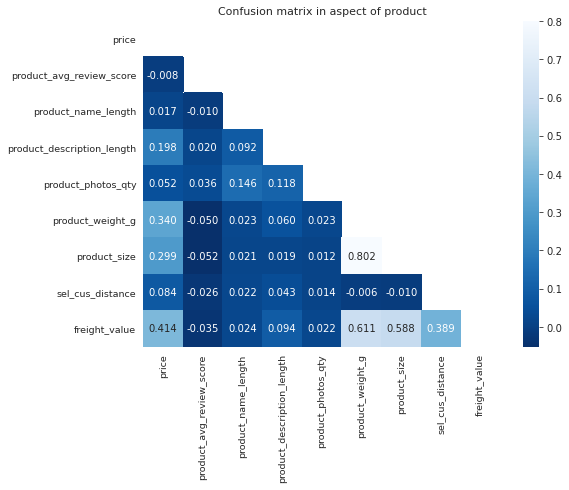

In [44]:
df_corr_item=pd.DataFrame(df_all, columns=['price','product_avg_review_score','product_name_length','product_description_length',
                                       'product_photos_qty', 'product_weight_g','product_size','sel_cus_distance', 'freight_value'])

corr2= df_corr_item.corr()
mask = np.zeros_like(corr2)
mask[np.triu_indices_from(corr2)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(corr2, mask=mask, annot=True, fmt=".3f", cmap= 'Blues_r')
plt.xticks(rotation=90);
plt.title("Confusion matrix in aspect of product", fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=9.5)
plt.savefig('seller_dis.png', dpi=300, bbox_inches='tight');
plt.show();